In [1]:
# -------------------------
# import
# -------------------------

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from models import *
from utils import *

In [3]:
# -------------------------
# config
# -------------------------

In [4]:
SEED = 42
DATA_PATH = "inputs/rheed_stoich_data.npz"
TRAIN_FRAC = 0.8
BATCH_SIZE = 4
DOWNSAMPLE_FACTOR = 1  # 540x720 -> 135x180
model = None

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
# -------------------------
# load data
# -------------------------

In [6]:
data = np.load(DATA_PATH)
stoich = data["stoich"].astype(np.float32).reshape(-1, 1)  # (N,1)
min_stoich, max_stoich = stoich.min(), stoich.max()
stoich = (stoich - min_stoich) / (max_stoich - min_stoich + 1e-8)
images = data["images"].astype(np.float32)                 # (N,H,W)
min_image, max_image = images.min(), images.max()
images = (images - min_image) / (max_image - min_image + 1e-8)

N, H, W = images.shape
IMG_HW = (H // DOWNSAMPLE_FACTOR, W // DOWNSAMPLE_FACTOR)

print("Loaded:", stoich.shape, images.shape, "-> downsampled to", IMG_HW)

Loaded: (31, 1) (31, 540, 720) -> downsampled to (540, 720)


In [7]:
# -------------------------
# dataloader
# -------------------------

In [8]:
all_idx = np.arange(N)
train_idx, test_idx = train_test_split(all_idx, train_size=TRAIN_FRAC, random_state=SEED, shuffle=True)

train_ds = PairedDataset(images, stoich, train_idx, IMG_HW, augment=False)
test_ds  = PairedDataset(images, stoich, test_idx, IMG_HW, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
print(len(all_idx), len(train_idx), len(test_idx), len(train_ds), len(test_ds), len(train_loader), len(test_loader))

31 24 7 24 7 6 2


In [10]:
# -------------------------
# train
# -------------------------

In [11]:
EPOCHS = 10000
LR = 1e-4
model=None ## comment this out if using a saved/pretrained model, code for loading pretrained model can be found later
if model is None:
    model = UniversalTranslator(IMG_HW).to(device)
model.train()
opt = torch.optim.Adam(model.parameters(), lr=LR)
for epoch in range(1, EPOCHS + 1):
    total = 0.0
    total_i2i = 0.0
    total_i2s = 0.0
    total_s2i = 0.0
    total_s2s = 0.0
    total_la = 0.0
    
    for img, sto in train_loader:
        img = img.to(device)   # (B,1,H,W)
        sto = sto.to(device)   # (B,1)

        out = model(img, sto)

        loss_i2i = F.mse_loss(out["img_i2i"], img)
        loss_i2s = F.mse_loss(out["sto_i2s"], sto)
        loss_s2i = F.mse_loss(out["img_s2i"], img)
        loss_s2s = F.mse_loss(out["sto_s2s"], sto)
        loss_la = F.mse_loss(out["z_img2"], out["z_sto2"])
        
        loss = 0.0
        loss += 1 * loss_i2i
        loss += 0.1 * loss_i2s
        loss += 10 * loss_s2i
        loss += 0.01 * loss_s2s
        loss += 0.001 * loss_la

        opt.zero_grad()
        loss.backward()
        opt.step()

        total += loss.item()
        total_i2i += loss_i2i.item()
        total_i2s += loss_i2s.item()
        total_s2i += loss_s2i.item()
        total_s2s += loss_s2s.item()
        total_la += loss_la.item()

    if epoch % int(EPOCHS/10) == 0 or epoch == 1:
        n = len(train_loader)
        print(
            f"Epoch {epoch:04d} | "
            f"total {total/n:.4f} | "
            f"i2i {total_i2i/n:.4f} | "
            f"i2s {total_i2s/n:.4f} | "
            f"s2i {total_s2i/n:.4f} | "
            f"s2s {total_s2s/n:.4f} | "
            f"latent {total_la/n:.4f}"
        )

/mnt/jawad_cnms_s1/jawad_server/code/20251216_code_hackathon_mx_rheed/env_chmr/lib/python3.11/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 0001 | total 2.1912 | i2i 0.1980 | i2s 0.1171 | s2i 0.1980 | s2s 0.1317 | latent 0.0219
Epoch 1000 | total 0.0390 | i2i 0.0014 | i2s 0.0000 | s2i 0.0037 | s2s 0.0658 | latent 0.1579
Epoch 2000 | total 0.0370 | i2i 0.0010 | i2s 0.0002 | s2i 0.0036 | s2s 0.0118 | latent 0.0691
Epoch 3000 | total 0.0312 | i2i 0.0009 | i2s 0.0001 | s2i 0.0030 | s2s 0.0114 | latent 0.0616
Epoch 4000 | total 0.0270 | i2i 0.0007 | i2s 0.0000 | s2i 0.0026 | s2s 0.0085 | latent 0.0678
Epoch 5000 | total 0.0258 | i2i 0.0006 | i2s 0.0000 | s2i 0.0025 | s2s 0.0077 | latent 0.0617
Epoch 6000 | total 0.0224 | i2i 0.0006 | i2s 0.0002 | s2i 0.0022 | s2s 0.0075 | latent 0.0515
Epoch 7000 | total 0.0211 | i2i 0.0005 | i2s 0.0000 | s2i 0.0021 | s2s 0.0071 | latent 0.0438
Epoch 8000 | total 0.0201 | i2i 0.0004 | i2s 0.0000 | s2i 0.0020 | s2s 0.0066 | latent 0.0395
Epoch 9000 | total 0.0191 | i2i 0.0005 | i2s 0.0001 | s2i 0.0019 | s2s 0.0064 | latent 0.0381
Epoch 10000 | total 0.0180 | i2i 0.0005 | i2s 0.0000 | s2i 0

In [12]:
# -------------------------
# saving model
# -------------------------

In [13]:
# torch.save(model.state_dict(), "outputs/model_weights.pth")

# np.savez(
#     "outputs/model_meta.npz",
#     min_stoich=min_stoich,
#     max_stoich=max_stoich,
#     min_image=min_image,
#     max_image=max_image,
#     IMG_HW=np.array(IMG_HW)
# )

# print("Model and metadata saved.")

In [14]:
# -------------------------
# loading previously saved model
# -------------------------

In [15]:
# model = UniversalTranslator(IMG_HW).to(device)
# model.load_state_dict(torch.load("outputs/model_weights.pth", map_location=device))
# model.eval()   # important for inference

In [16]:
# -------------------------
# evaluation
# -------------------------

True stoich: 52.4496 | Predicted stoich: 52.3126


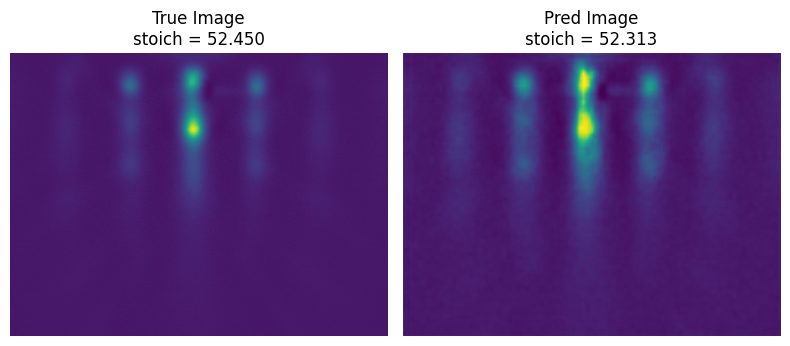

True stoich: 41.0214 | Predicted stoich: 40.8776


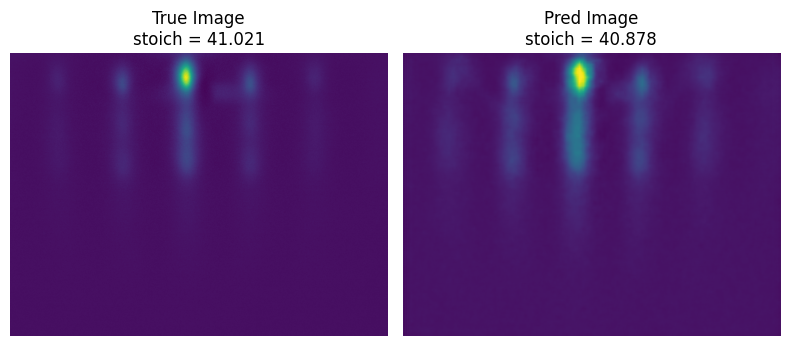

True stoich: 47.1691 | Predicted stoich: 47.1293


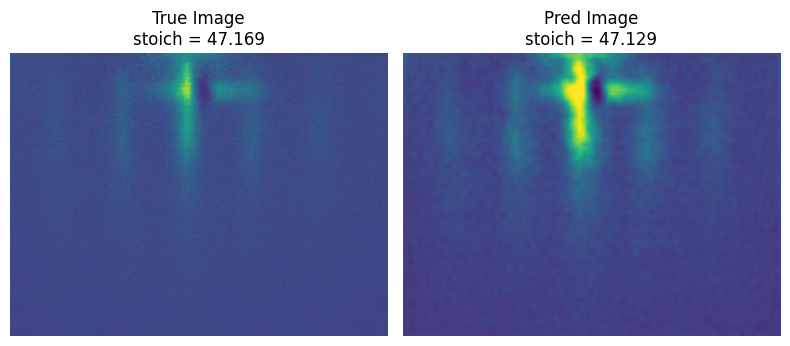

In [22]:
for i in train_idx[:3]:

    # ---- Ground truth ----
    true_img = data["images"][i]
    true_sto = float(data["stoich"][i])

    # ---- Prediction from image ----
    img_pred, sto_pred = predict_from_input(
        model=model,
        input_data=true_img,
        input_type="img",
        IMG_HW=IMG_HW,
        min_stoich=min_stoich,
        max_stoich=max_stoich,
        min_image=min_image,
        max_image=max_image,
        device=device
    )

    print(f"True stoich: {true_sto:.4f} | Predicted stoich: {sto_pred:.4f}")

    # ---- Plot ----
    fig, axes = plt.subplots(1, 2, figsize=(8,4))

    axes[0].imshow(true_img, cmap="viridis")
    axes[0].set_title(f"True Image\nstoich = {true_sto:.3f}")
    axes[0].axis("off")

    axes[1].imshow(img_pred, cmap="viridis")
    axes[1].set_title(f"Pred Image\nstoich = {sto_pred:.3f}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

True stoich: 61.0268 | Predicted stoich: 54.3745


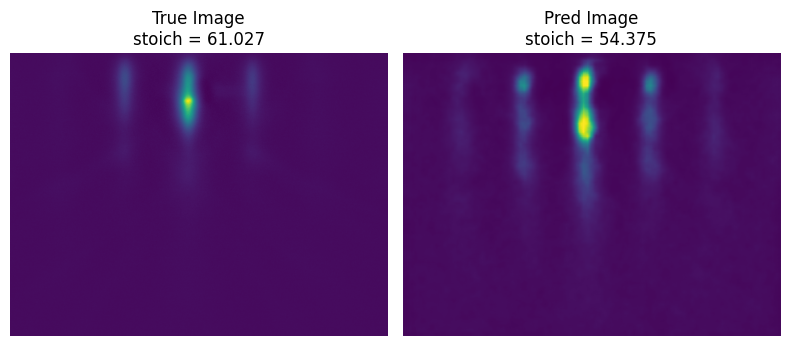

True stoich: 37.1403 | Predicted stoich: 36.3841


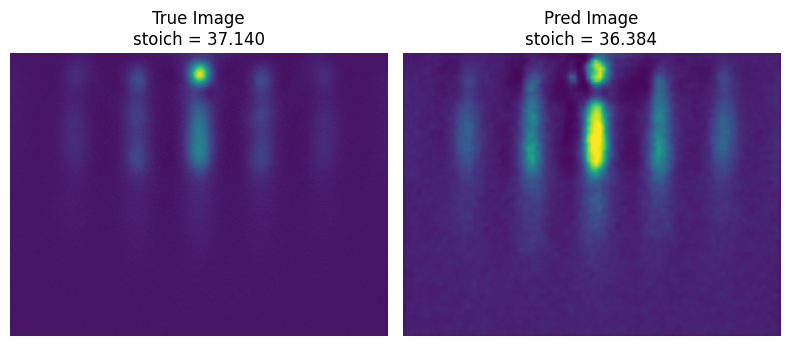

True stoich: 56.1305 | Predicted stoich: 47.5637


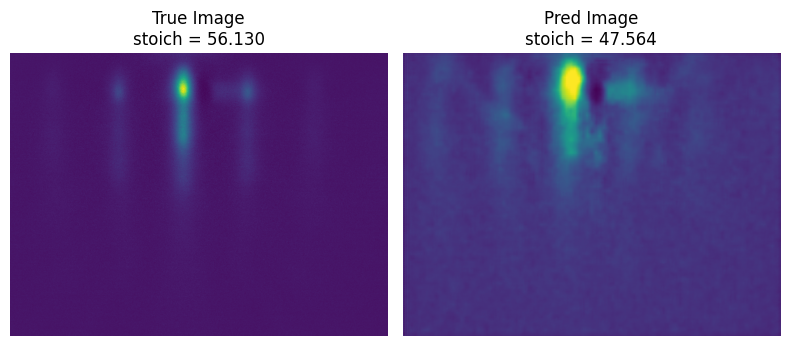

In [23]:
for i in test_idx[:3]:

    # ---- Ground truth ----
    true_img = data["images"][i]
    true_sto = float(data["stoich"][i])

    # ---- Prediction from image ----
    img_pred, sto_pred = predict_from_input(
        model=model,
        input_data=true_img,
        input_type="img",
        IMG_HW=IMG_HW,
        min_stoich=min_stoich,
        max_stoich=max_stoich,
        min_image=min_image,
        max_image=max_image,
        device=device
    )

    print(f"True stoich: {true_sto:.4f} | Predicted stoich: {sto_pred:.4f}")

    # ---- Plot ----
    fig, axes = plt.subplots(1, 2, figsize=(8,4))

    axes[0].imshow(true_img, cmap="viridis")
    axes[0].set_title(f"True Image\nstoich = {true_sto:.3f}")
    axes[0].axis("off")

    axes[1].imshow(img_pred, cmap="viridis")
    axes[1].set_title(f"Pred Image\nstoich = {sto_pred:.3f}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()